# Monthly Decision Tree Baseline (Experimental)

- 목적: merged_monthly.csv 기반으로 의사결정트리 회귀 모델의 베이스라인 성능을 확인하고,
  주요 피처 중요도와 트리 구조를 테스트하는 실험 노트북이다.
- 최종 모델 코드는 `backend/modeling/daily_risk_index/monthly_tree_and_daily_risk.py`에 정리되어 있다.
- 이 노트북은 탐색용(Exploratory) 기록이며, 리포트/발표에 직접 사용되는 결과는 아니다.

In [82]:
import pandas as pd

df = pd.read_csv("../data/processed/mart/merged_monthly.csv")
df.head()

,year,month,ym,sido_name,resp_total,pm25_mean,pm10_mean,pm25_p90,pm10_p90,pm25_alert_days,pm10_alert_days,t_mean_month,rh_mean_month,precip_sum_month,wind_mean_month,population,resp_rate_total
0,2018,1,2018-01,강원,74388,21.736559,41.505376,39.750000,70.750000,5.0,0.0,-3.88,48.4,4.20,2.44,1548078,4805.184235
1,2018,2,2018-02,강원,43440,19.720238,44.380952,32.608333,65.691667,1.0,0.0,-2.22,46.8,42.70,2.48,1546259,2809.361174
2,2018,3,2018-03,강원,41909,19.137097,41.642473,32.916667,74.250000,2.0,0.0,7.00,59.8,61.66,2.48,1546152,2710.535575
3,2018,4,2018-04,강원,42312,17.313889,48.875000,25.000000,82.050000,0.0,1.0,12.24,56.2,134.78,2.54,1545452,2737.839804
4,2018,5,2018-05,강원,39729,15.150538,37.647849,25.333333,62.750000,0.0,0.0,16.26,70.0,180.54,2.18,1545291,2570.972069


In [83]:
# 시차(lag) 만들기 위한 정렬
df = df.sort_values(["sido_name", "year", "month"])

g = df.groupby("sido_name")

# lag 컬럼 생성
df["pm25_mean_lag1m"] = g["pm25_mean"].shift(1)
df["t_mean_month_lag1m"] = g["t_mean_month"].shift(1)
df["resp_rate_total_lag1m"] = g["resp_rate_total"].shift(1)

# lag가 NaN인 첫 달 행 제거
df_model = df.dropna(
    subset=["pm25_mean_lag1m", "t_mean_month_lag1m", "resp_rate_total_lag1m"]
).copy()

df_model.head()

,year,month,ym,sido_name,resp_total,pm25_mean,pm10_mean,pm25_p90,pm10_p90,pm25_alert_days,pm10_alert_days,t_mean_month,rh_mean_month,precip_sum_month,wind_mean_month,population,resp_rate_total,pm25_mean_lag1m,t_mean_month_lag1m,resp_rate_total_lag1m
1,2018,2,2018-02,강원,43440,19.720238,44.380952,32.608333,65.691667,1.0,0.0,-2.22,46.8,42.70,2.48,1546259,2809.361174,21.736559,-3.88,4805.184235
2,2018,3,2018-03,강원,41909,19.137097,41.642473,32.916667,74.250000,2.0,0.0,7.00,59.8,61.66,2.48,1546152,2710.535575,19.720238,-2.22,2809.361174
3,2018,4,2018-04,강원,42312,17.313889,48.875000,25.000000,82.050000,0.0,1.0,12.24,56.2,134.78,2.54,1545452,2737.839804,19.137097,7.00,2710.535575
4,2018,5,2018-05,강원,39729,15.150538,37.647849,25.333333,62.750000,0.0,0.0,16.26,70.0,180.54,2.18,1545291,2570.972069,17.313889,12.24,2737.839804
5,2018,6,2018-06,강원,29648,13.777778,31.286111,21.850000,46.425000,0.0,0.0,21.54,66.8,80.90,1.86,1544843,1919.159423,15.150538,16.26,2570.972069


In [84]:
# y
y = df_model["resp_rate_total"]

# X
feature_cols = [
    "pm25_mean",
    "pm10_mean",
    "pm25_p90",
    "pm10_p90",
    "pm25_alert_days",
    "pm10_alert_days",
    "t_mean_month",
    "rh_mean_month",
    "precip_sum_month",
    "wind_mean_month",
    "month",
    "resp_rate_total_lag1m",
]

X = df_model[feature_cols]

In [85]:
# X, y 둘 중 하나라도 NaN 있으면 제거
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
df_model = df_model[mask]

X.shape, y.shape

((1238, 12), (1238,))

In [86]:
# 학습: 2018~2022, 테스트: 2023~2024 (원하면 기준 연도 바꿀 수 있음)
train_mask = df_model["year"] <= 2022
test_mask = df_model["year"] >= 2023

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train.shape, X_test.shape

((900, 12), (338, 12))

In [87]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(
    max_depth=4,  # 발표용 트리 구조 보기에 적당한 깊이
    min_samples_leaf=10,
    random_state=42,
)

tree.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Train MAE :", mae_train)
print("Test  MAE :", mae_test)
print("Train RMSE:", rmse_train)
print("Test  RMSE:", rmse_test)

Train MAE : 281.2322043803782
Test  MAE : 337.0741308842762
Train RMSE: 383.2725315227163
Test  RMSE: 422.7534066840178


In [89]:
import pandas as pd

fi = pd.Series(tree.feature_importances_, index=feature_cols).sort_values(
    ascending=False
)
fi

resp_rate_total_lag1m    0.856577
t_mean_month             0.070073
month                    0.040778
rh_mean_month            0.022628
pm10_alert_days          0.009944
pm25_mean                0.000000
pm10_mean                0.000000
pm25_p90                 0.000000
pm10_p90                 0.000000
pm25_alert_days          0.000000
precip_sum_month         0.000000
wind_mean_month          0.000000
dtype: float64

In [90]:
from sklearn.tree import export_text

tree_rules = export_text(tree, feature_names=list(X.columns))
print(tree_rules)

|--- resp_rate_total_lag1m <= 1920.59
|   |--- resp_rate_total_lag1m <= 1240.51
|   |   |--- resp_rate_total_lag1m <= 922.84
|   |   |   |--- resp_rate_total_lag1m <= 718.53
|   |   |   |   |--- value: [686.47]
|   |   |   |--- resp_rate_total_lag1m >  718.53
|   |   |   |   |--- value: [888.56]
|   |   |--- resp_rate_total_lag1m >  922.84
|   |   |   |--- month <= 8.50
|   |   |   |   |--- value: [1069.11]
|   |   |   |--- month >  8.50
|   |   |   |   |--- value: [1319.99]
|   |--- resp_rate_total_lag1m >  1240.51
|   |   |--- resp_rate_total_lag1m <= 1600.38
|   |   |   |--- month <= 8.50
|   |   |   |   |--- value: [1438.04]
|   |   |   |--- month >  8.50
|   |   |   |   |--- value: [1643.13]
|   |   |--- resp_rate_total_lag1m >  1600.38
|   |   |   |--- pm10_alert_days <= 0.50
|   |   |   |   |--- value: [1757.61]
|   |   |   |--- pm10_alert_days >  0.50
|   |   |   |   |--- value: [2448.08]
|--- resp_rate_total_lag1m >  1920.59
|   |--- t_mean_month <= 18.79
|   |   |--- month <=

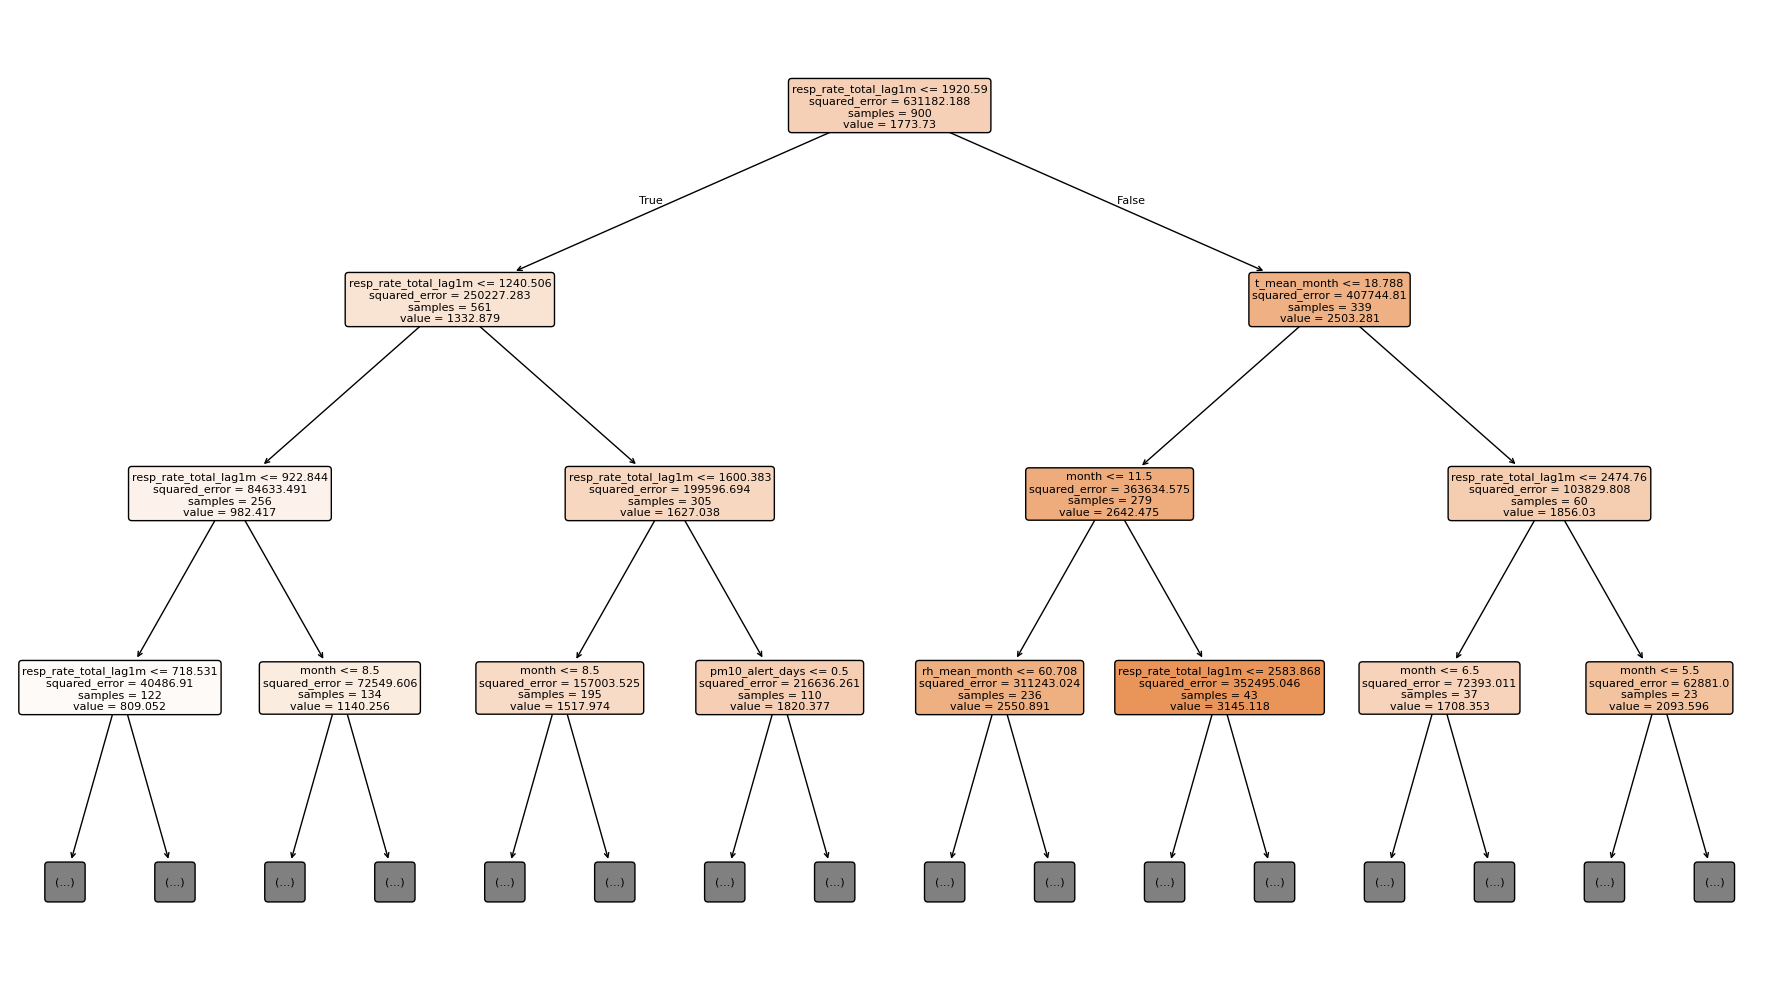

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(18, 10))
plot_tree(
    tree,
    feature_names=feature_cols,
    filled=True,
    rounded=True,
    max_depth=3, 
    fontsize=8,
)
plt.tight_layout()

plt.savefig("figures/tree_regression_depth3.png", dpi=200)
plt.show()